# Chapter 5 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Sampling for Estimation of Finite Population Quantities

In [2]:
import random
import numpy as np
import pingouin as pg
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import mistat

## Sampling and the Estimation Problem

### Basic Definitions

### Drawing a Random Sample from a Finite Population

In [3]:
random.sample(range(1, 101), k=10)

[51, 96, 18, 14, 85, 76, 34, 41, 73, 87]

### Sample Estimates of Population Quantities and their Sampling Distribution

In [4]:
# range is a generator and needs to be converted to a list
X = list(range(1, 101))
Xsample = random.choices(X, k=20)

In [5]:
df = pd.DataFrame({f'sample {i}': random.choices(X, k=20)
                  for i in range(1, 5)})
df.agg(['mean', 'std'])

sample 1   sample 2   sample 3   sample 4
mean  46.35000  51.850000  49.550000  46.400000
std   28.63431  29.790982  28.702604  28.801316

In [6]:
np.random.seed(1)

X = list(range(100))

# compute_bootci creates samples of the same size as the population
# as we are interested in a smaller sample of size 20, we ignore the
# remaining values when we calculate the mean
def stat_func(sample):
    return np.mean(sample[:20])

B = pg.compute_bootci(X, func=stat_func, n_boot=1000,
                      return_dist=True, seed=1)
print('Mean values of first three mean values: ', B[1][:3])
pd.cut(B[1], bins=12).value_counts()

Mean values of first three mean values:  [61.15 46.25 55.15]


(30.907, 34.529]      6
(34.529, 38.108]     30
(38.108, 41.688]     79
(41.688, 45.267]    137
(45.267, 48.846]    191
(48.846, 52.425]    226
(52.425, 56.004]    172
(56.004, 59.583]    101
(59.583, 63.163]     42
(63.163, 66.742]     13
(66.742, 70.321]      2
(70.321, 73.9]        1
Name: count, dtype: int64

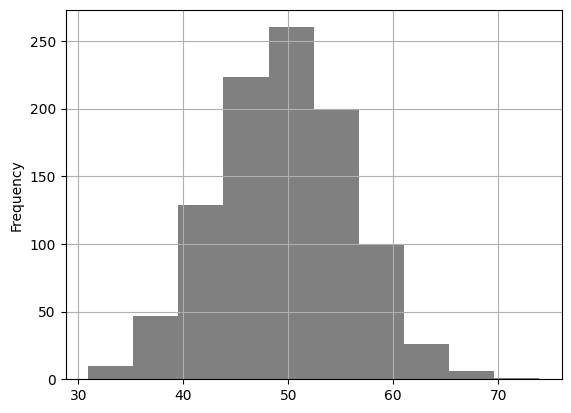

In [7]:
ax = pd.Series(B[1]).hist(color='grey')
ax.set_ylabel('Frequency')
plt.show()

## Estimation with Simple Random Samples

In [8]:
random.seed(2)
population = list(range(1, 101))

# create samples of size 20 and collect mean and standard deviation
rswr = {'mean': [], 'var': []}
rswor = {'mean': [], 'var': []}
for _ in range(100):
    sample = np.array(random.choices(population, k=10))
    rswr['mean'].append(sample.mean())
    rswr['var'].append(sample.var(ddof=1))

    sample = np.array(random.sample(population, k=10))
    rswor['mean'].append(sample.mean())
    rswor['var'].append(sample.var(ddof=1))

# calculate mean and standard deviation of sample estimates
from collections import namedtuple
SampleStats = namedtuple('SampleStats', 'X10,S2_10')
def calcStats(values):
    return SampleStats(np.mean(values), np.std(values, ddof=1))
rswr['mean'] = calcStats(rswr['mean'])
rswr['var'] = calcStats(rswr['var'])
rswor['mean'] = calcStats(rswor['mean'])
rswor['var'] = calcStats(rswor['var'])

In [9]:
print('RSWR')
print(f" Est. mean: {rswr['mean'].X10:.2f} / {rswr['mean'].S2_10:.3f}")
print(f" Est. var : {rswr['var'].X10:.2f} / {rswr['var'].S2_10:.2f}")
print('RSWOR')
print(f" Est. mean: {rswor['mean'].X10:.2f} / {rswor['mean'].S2_10:.3f}")
print(f" Est. var : {rswor['var'].X10:.2f} / {rswor['var'].S2_10:.2f}")

RSWR
 Est. mean: 51.60 / 10.684
 Est. var : 802.65 / 243.01
RSWOR
 Est. mean: 50.44 / 8.388
 Est. var : 828.04 / 252.10


### Properties of $\bar X_n$ and $S^2_n$ under RSWR

In [10]:
place = mistat.load_data('PLACE')
xDev = place['xDev'] / 1e-3
N = len(xDev)
mu_N = xDev.mean()
sigma2_N = xDev.var(ddof=0)
mu_3N = np.sum((xDev - mu_N) ** 3) / N
mu_4N = np.sum((xDev - mu_N) ** 4) / N
print(f'mu_N: {mu_N:.4f}')
print(f'sigma2_N: {sigma2_N:.5f}')
print(f'mu_3N: {mu_3N:.5f}')
print(f'mu_4N: {mu_4N:.3f}')

mu_N: 0.9124
sigma2_N: 2.91992
mu_3N: -0.98326
mu_4N: 14.655


### Properties of $\bar X_n$ and $S^2_n$ under RSWOR

In [11]:
random.seed(1)
X = list(range(1, 101))

def confInt(x, p, N):
    if p >= 0.5:
        p = 1 - (1 - p) / 2
    else:
        p = 1 - p / 2

    n = len(x)
    z = stats.norm.ppf(p) * np.sqrt(1 - (n-1)/(N-1)) / np.sqrt(n)
    m = np.mean(x)
    s = np.std(x, ddof=1)
    return (m - z * s, m + z * s)

sampled_confInt = []
for _ in range(1000):
    sample = random.sample(X, k=30)
    sampled_confInt.append(confInt(sample, p=0.95, N=100))

# show the first three results
print(sampled_confInt[:3])

# calculate the ratio of cases where the actual mean of 50.5
# is inside the sample confidence intervals
proportion_coverage = sum(ci[0] < 50.5 < ci[1] for ci in sampled_confInt)
proportion_coverage = proportion_coverage / len(sampled_confInt)
print(proportion_coverage)

[(36.85179487364511, 55.14820512635489), (44.070802021276585, 60.795864645390076), (43.237002670283765, 59.56299732971623)]
0.943


## Estimating the Mean with Stratified RSWOR

## Proportional and Optimal Allocation

## Prediction Models with Known Covariates

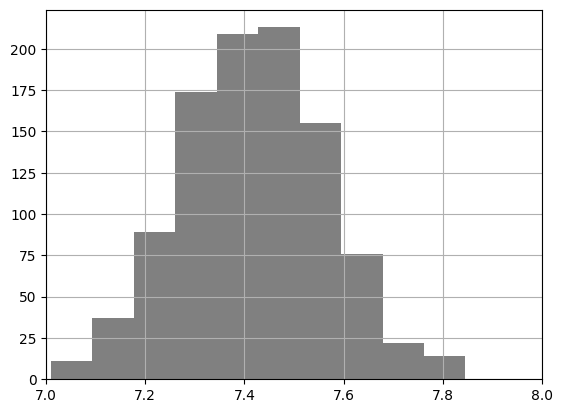

In [12]:
pred = mistat.load_data('PRED')

def stat_func(x):
    return np.mean(x[:100]) * 0.05

B = pg.compute_bootci(pred['x'], func=stat_func, n_boot=1000, return_dist=True, seed=1)
ax = pd.Series(B[1]).hist(color='grey')
ax.set_xlim(7, 8)
plt.show()

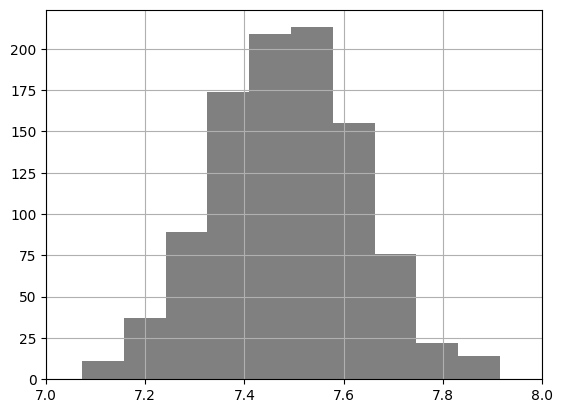

In [13]:
pred = mistat.load_data('PRED')

def stat_func(x):
    return np.mean(x[:100]) * 7.495 / 148.58

B = pg.compute_bootci(pred['x'], func=stat_func, n_boot=1000, return_dist=True, seed=1)
ax = pd.Series(B[1]).hist(color='grey')
ax.set_xlim(7, 8)
plt.show()

## Chapter Highlights

## Exercises